# **PACKET BASED INTRUSION DETECTION ON NSL-KDD DATASET**

## **Environment Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Importing Libraries**

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import imblearn
import sklearn
%matplotlib inline

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## **Load Data**
Datasets with 3 different CSV files, each contains same type of attack data at different times.

In [3]:
features = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
          'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
          'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
          'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
          'num_access_files', 'num_outbound_cmds', 'is_host_login',
          'is_guest_login', 'count', 'srv_count', 'serror_rate',
          'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
          'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
          'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
          'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
          'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
          'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']

In [4]:
# Load NSL_KDDTrain dataset
kddTrain = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Datasets/KDDTrain+.txt', names=features)

# Load NSL_KDDTest dataset
kddTest = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Datasets/KDDTest+.txt', names=features)

kddTrain.shape, kddTest.shape

((125973, 43), (22544, 43))

In [5]:
# Combining all tables into one dataset. This is possilbe since all tables have the same columns,
# as we checked in the cell above.
combinedData = pd.concat([kddTrain, kddTest]).drop_duplicates(keep=False)
combinedData.reset_index(drop=True, inplace = True)

In [6]:
print('Data has {} rows & {} columns'.format(combinedData.shape[0],combinedData.shape[1]))

Data has 147297 rows & 43 columns


In [7]:
combinedData.tail(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
147294,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
147295,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
147296,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.08,0.03,0.00,0.00,0.00,0.0,0.44,1.00,mscan,14


In [8]:
combinedData.dtypes.value_counts()

int64      24
float64    15
object      4
dtype: int64

Some general info about the dataset. It contains roughly 148517 rows across 43 columns. Data consists of mostly int64 and float64 types, except 4 attributes of 'object' type.

## **Data Cleaning**
This section contains data cleaning code. We go through the process of renaming columns, removing NaN to get the data ready for visualization and model training.

### Renaming columns

In [9]:
# Removing whitespaces in column names.
attacks = [col.replace(' ', '') for col in combinedData.columns]
combinedData.columns = attacks

In [10]:
# lets see that 'subclass' column contains some wierd characters. 
combinedData["attack_type"].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl', 'saint', 'mscan', 'apache2',
       'snmpgetattack', 'processtable', 'httptunnel', 'ps', 'snmpguess',
       'mailbomb', 'named', 'sendmail', 'xterm', 'worm', 'xlock',
       'xsnoop', 'sqlattack', 'udpstorm'], dtype=object)

### Removing NULL values

In [11]:
# Checking if there are any NULL values in the dataset.
combinedData.isnull().values.any()

False

In [12]:
# Checking which column/s contain NULL values.
[col for col in combinedData if combinedData[col].isnull().values.any()]

[]

In [13]:
# since num_outbound_cmds is a redundant colums, so remove it from dataset
print(combinedData['num_outbound_cmds'].value_counts())
combinedData.drop(['num_outbound_cmds'], axis=1, inplace=True)
combinedData.drop(['difficulty_level'], axis=1, inplace=True)

0    147297
Name: num_outbound_cmds, dtype: int64


In [14]:
combinedData.isnull().any().any()

False

## **Data Visualization**

In [15]:
# There are 8 different type of attacks apart from normal in Dataset 
print(combinedData['attack_type'].unique())
len(combinedData['attack_type'].unique())

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl' 'saint' 'mscan' 'apache2' 'snmpgetattack'
 'processtable' 'httptunnel' 'ps' 'snmpguess' 'mailbomb' 'named'
 'sendmail' 'xterm' 'worm' 'xlock' 'xsnoop' 'sqlattack' 'udpstorm']


40

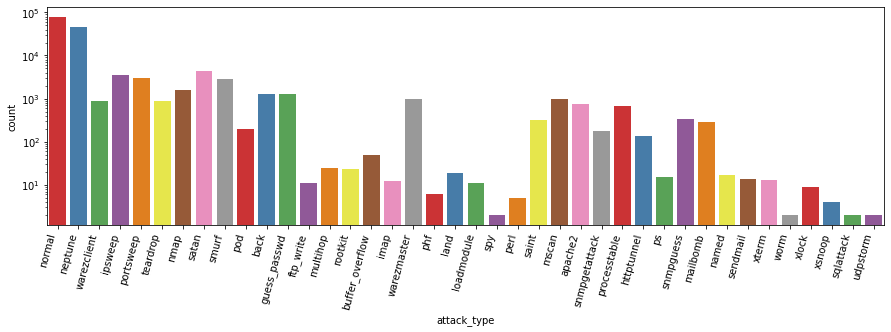

In [16]:
#lets see which attack is having more impact on dataset
plt.figure(figsize=(15,4))
g = sns.countplot( data = combinedData, x = 'attack_type', palette="Set1")
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=75, ha="right")
plt.savefig('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Images/various_attacks.png')
plt.show()

In [17]:
for i in range(len(combinedData['attack_type'])):
      if combinedData['attack_type'][i] in ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']:
        combinedData['attack_type'][i] = 'Dos'
      elif combinedData['attack_type'][i] in ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']:
        combinedData['attack_type'][i] = 'U2R'
      elif combinedData['attack_type'][i] in ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail', 'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop']:
        combinedData['attack_type'][i] = 'R2L'
      elif combinedData['attack_type'][i] in ['ipsweep','mscan','nmap','portsweep','saint','satan']:
        combinedData['attack_type'][i] = 'Probe'

combinedData['attack_type'].value_counts()

normal    76880
Dos       52587
Probe     13831
R2L        3880
U2R         119
Name: attack_type, dtype: int64

In [18]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = combinedData.copy()
multi_label = pd.DataFrame(multi_data.attack_type)

In [19]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

In [20]:
np.save("/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Labels/Labels.npy",le2.classes_,allow_pickle=True)

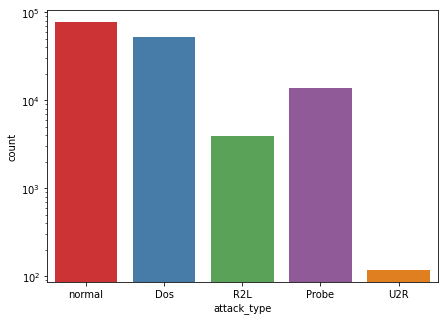

In [21]:
#lets see which attack is having more impact on dataset
plt.figure(figsize=(7,5))
g = sns.countplot( data = multi_data, x = 'attack_type', palette="Set1")
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels())
plt.savefig('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Images/attacks_grp.png')
plt.show()

## **Encoding Categorical Attributes**

Separating Features and target for Model training

In [22]:
XX = combinedData.iloc[:,:-1].values
YY = combinedData.iloc[:,-1].values
YY = YY.reshape(-1,1)
print([XX.shape, YY.shape])
YY

[(147297, 40), (147297, 1)]


array([['normal'],
       ['normal'],
       ['Dos'],
       ...,
       ['normal'],
       ['Dos'],
       ['Probe']], dtype=object)

Visualizing string features

In [23]:
combinedData.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder()
ohe = OneHotEncoder()

XX[:,1] = encoder.fit_transform(XX[:,1])
XX[:,2] = encoder.fit_transform(XX[:,2])
XX[:,3] = encoder.fit_transform(XX[:,3])

yy = encoder.fit_transform(YY).reshape(-1,1)
YY = ohe.fit_transform(yy).toarray()
XX.shape, YY.shape
YY

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [25]:
combinedData.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')

In [26]:
cols_ = ['Duration', 'Protocol_Type', 'Service', 'Flag', 'Src_Bytes',
       'Dst_Bytes', 'Land', 'Wrong_Fragment', 'Urgent', 'Hot',
       'Num_Failed_Logins', 'Logged_in', 'Num_Compromised', 'Root_shell',
       'Su_attempted', 'Num_Root', 'Num_File_Creations', 'Num_shells',
       'Num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [27]:
dataX = pd.DataFrame(XX,columns=cols_)
dataY = pd.DataFrame(yy)
dataY

,0
0,4
1,4
2,0
3,4
4,4
...,...
147292,0
147293,4
147294,4
147295,0


## **Feature Selection**
Since there is such a large number of features, it is possible that some features are redundant. Let us print a correlation matrix

In [28]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import itertools    

model_ = DecisionTreeClassifier()

# create RFE model and select 15 attributes
rec = RFE(model_, n_features_to_select = 15)
rec = rec.fit(dataX, dataY)

# summarize the selection of the attributes
featuresMap = [(x, n) for x, n in itertools.zip_longest(rec.get_support(), dataX.columns)]
selectedFeatures = [n for x, n in featuresMap if x == True]

print(selectedFeatures)

['Duration', 'Protocol_Type', 'Service', 'Src_Bytes', 'Dst_Bytes', 'Num_Failed_Logins', 'is_guest_login', 'count', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']


Selecting Features

In [57]:
dataX = dataX[selectedFeatures]
X = dataX[selectedFeatures]
print('15 selected features \n')
X.head()

15 selected features 



,Duration,Protocol_Type,Service,Src_Bytes,Dst_Bytes,Num_Failed_Logins,is_guest_login,count,diff_srv_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate
0,0,1,20,491,0,0,0,2,0.0,150,0.17,0.03,0.17,0.0,0.0
1,0,2,44,146,0,0,0,13,0.15,255,0.0,0.6,0.88,0.0,0.0
2,0,1,49,0,0,0,0,123,0.07,255,0.1,0.05,0.0,1.0,0.0
3,0,1,24,232,8153,0,0,5,0.0,30,1.0,0.0,0.03,0.01,0.01
4,0,1,24,199,420,0,0,30,0.0,255,1.0,0.0,0.0,0.0,0.0


## **Dataset Splitting**
The next step is to split training and testing data. For this we will use sklearn function train_test_split(). This step is important so we can have representative data for evaluating our model. Both train and test samples should contain similar data variance.

In [31]:
from sklearn.model_selection import train_test_split
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().

In [32]:
from sklearn.model_selection import train_test_split
i_train, i_test, j_train, j_test = train_test_split(dataX, dataY, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)

In [33]:
i_train.shape, j_train.shape, i_test.shape, j_test.shape    # test is larger... good 

((103107, 15), (103107, 1), (44190, 15), (44190, 1))

## **Scaling Numerical Attributes**
The next few cells contain the code for scaling the data into the size adequate for the Models.

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
i_train = sc.fit_transform(i_train)
i_test = sc.transform(i_test)
i_train.shape, i_test.shape

((103107, 15), (44190, 15))

## **Machine-Learning model training**

importing required libraries for ml model

In [35]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error,roc_auc_score,cohen_kappa_score)
import sklearn.metrics as metrics

### Training four base learners: decision tree, random forest, XGBoost

#### Apply DT

Training Decision Tree

Accuracy of Decision Tree: 0.9937995021498076
              precision    recall  f1-score   support

         Dos       1.00      1.00      1.00     15831
       Probe       0.99      0.99      0.99      4160
         R2L       0.94      0.95      0.95      1159
         U2R       0.54      0.56      0.55        39
      normal       1.00      0.99      0.99     23001

    accuracy                           0.99     44190
   macro avg       0.89      0.90      0.90     44190
weighted avg       0.99      0.99      0.99     44190



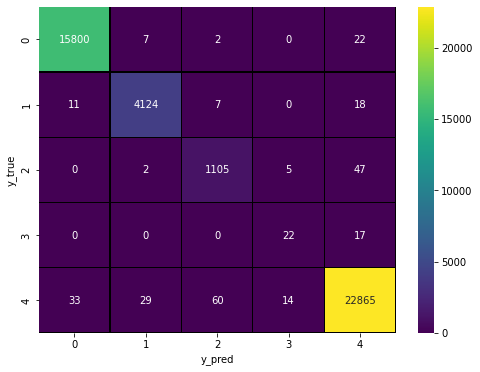

In [36]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(i_train, j_train) 

y_predict=dt.predict(i_test)
y_true=j_test

dt_score=dt.score(i_test, j_test)
print('Accuracy of Decision Tree: '+ str(dt_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply RF

Training Random Forest

Accuracy of Random Forest: 0.9953383118352569
              precision    recall  f1-score   support

         Dos       1.00      1.00      1.00     15831
       Probe       0.99      1.00      1.00      4160
         R2L       0.98      0.94      0.96      1159
         U2R       0.76      0.33      0.46        39
      normal       0.99      1.00      1.00     23001

    accuracy                           1.00     44190
   macro avg       0.95      0.85      0.88     44190
weighted avg       1.00      1.00      1.00     44190



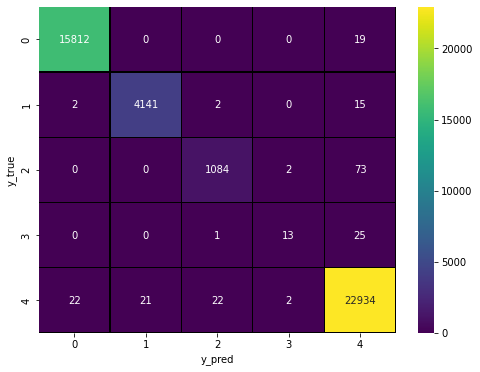

In [37]:
##@title  { vertical-output: true, display-mode: "both" }
rf = RandomForestClassifier(random_state = 0)
rf.fit(i_train, j_train) 

y_predict=rf.predict(i_test)
y_true=j_test

rf_score=rf.score(i_test, j_test)
print('Accuracy of Random Forest: '+ str(rf_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply XGBoost

Training XGBoost

Accuracy of Gradient Boosting: 0.9574564381081693
              precision    recall  f1-score   support

         Dos       0.98      0.98      0.98     15831
       Probe       0.92      0.92      0.92      4160
         R2L       0.99      0.26      0.42      1159
         U2R       0.00      0.00      0.00        39
      normal       0.95      0.98      0.97     23001

    accuracy                           0.96     44190
   macro avg       0.77      0.63      0.66     44190
weighted avg       0.96      0.96      0.95     44190



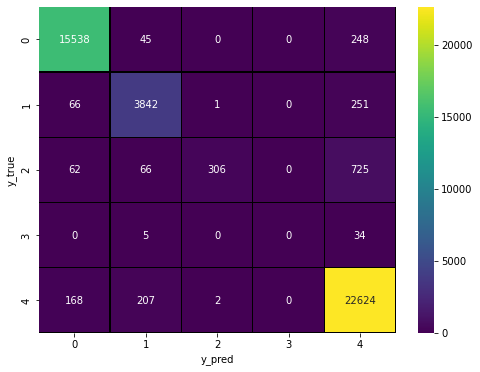

In [38]:
##@title  { vertical-output: true, display-mode: "both" }
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(i_train,j_train)

y_predict=xg.predict(i_test)
y_true=j_test

xg_score=xg.score(i_test, j_test)
print('Accuracy of Gradient Boosting: '+ str(xg_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## **Deep-Learning Model Training**
In this stage we go by explaning parts of the network and its hyperparameters.

### Bi-directional LSTM Model


In [40]:
#importing lobraries
import keras
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense,Dropout, BatchNormalization, Activation, Bidirectional, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_res, y_res = sm.fit_resample(X,YY)

In [42]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_res, y_res,  train_size=0.7, test_size=0.3,  random_state = 1, shuffle=True)
print([Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape])

[(269080, 15), (115320, 15), (269080, 5), (115320, 5)]


In [43]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
Xtrain.shape, Xtest.shape

((269080, 15), (115320, 15))

### Reshaping our data into 3D, which is required format of LSTM input

In [44]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1], 1)
Xtrain.shape, Xtest.shape

((269080, 15, 1), (115320, 15, 1))

### Structure of our BiLSTM

In [45]:
timesteps = 60

In [46]:
blstm_model = tf.keras.Sequential()
blstm_model.add(Bidirectional(LSTM(60, return_sequences=True, activation= 'relu', input_shape=(Xtrain.shape[1], timesteps, 1))))
blstm_model.add(Bidirectional(LSTM(60,return_sequences= False, activation= 'relu')))
blstm_model.add(tf.keras.layers.Dropout(0.2))
blstm_model.add(Dense(5, activation= 'softmax'))
blstm_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history2 = blstm_model.fit(Xtrain, Ytrain,  epochs=10, validation_split=0.3, batch_size=700).history
#model.summary()

Epoch 1/10
270/270 [==============================] - 111s 386ms/step - loss: 0.8949 - accuracy: 0.6537 - val_loss: 0.7153 - val_accuracy: 0.7399
Epoch 2/10
270/270 [==============================] - 103s 383ms/step - loss: 0.4432 - accuracy: 0.8437 - val_loss: 0.3691 - val_accuracy: 0.8661
Epoch 3/10
270/270 [==============================] - 103s 383ms/step - loss: 0.3469 - accuracy: 0.8819 - val_loss: 0.2823 - val_accuracy: 0.9065
Epoch 4/10
270/270 [==============================] - 104s 385ms/step - loss: 0.2961 - accuracy: 0.9008 - val_loss: 0.3288 - val_accuracy: 0.8845
Epoch 5/10
270/270 [==============================] - 105s 387ms/step - loss: 0.2710 - accuracy: 0.9085 - val_loss: 0.2457 - val_accuracy: 0.9147
Epoch 6/10
270/270 [==============================] - 105s 388ms/step - loss: 0.2529 - accuracy: 0.9138 - val_loss: 0.2404 - val_accuracy: 0.9200
Epoch 7/10
270/270 [==============================] - 104s 386ms/step - loss: 0.2403 - accuracy: 0.9176 - val_loss: 0.2502 -

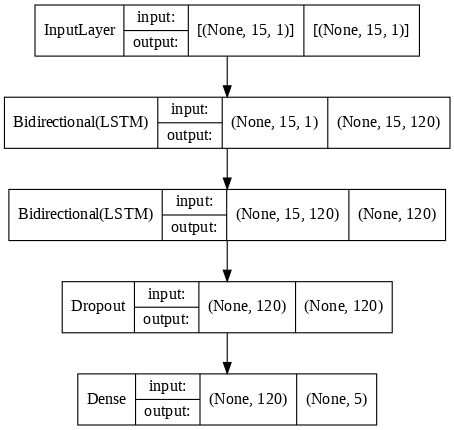

In [47]:
plot_model(blstm_model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

Evaluating our trained BiLSTM

3604/3604 [==============================] - 39s 11ms/step - loss: 0.2319 - accuracy: 0.9099
Accuracy of BLSTM: 0.9098681807518005
Precision of BLSTM: 0.9098596058611746
Recall of BLSTM: 0.9098681928546652
F1-score of BLSTM: 0.9098069111069308
              precision    recall  f1-score   support

         Dos       0.97      0.96      0.97     23096
       Probe       0.95      0.98      0.96     23060
         R2L       0.88      0.87      0.87     23152
         U2R       0.87      0.86      0.86     22996
      normal       0.88      0.89      0.89     23016

    accuracy                           0.91    115320
   macro avg       0.91      0.91      0.91    115320
weighted avg       0.91      0.91      0.91    115320



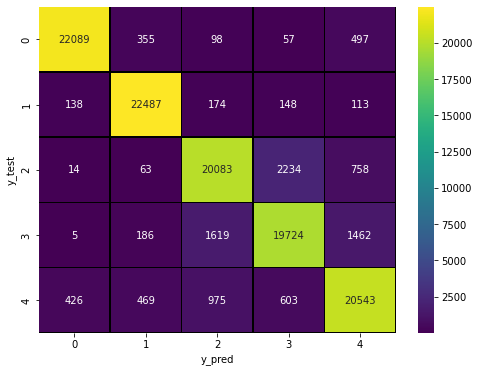

In [48]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
blstm_score = blstm_model.evaluate(Xtest, Ytest)
y_pred=blstm_model.predict(Xtest)
b_predict=np.argmax(y_pred, axis=1)
b_test=np.argmax(Ytest, axis=1)


print('Accuracy of BLSTM: '+ str(blstm_score[1]))

precision,recall,fscore,none= precision_recall_fscore_support(b_test,np.round(b_predict), average='weighted') 
print('Precision of BLSTM: '+(str(precision)))
print('Recall of BLSTM: '+(str(recall)))
print('F1-score of BLSTM: '+(str(fscore)))
print(metrics.classification_report(b_test, np.round(b_predict), target_names=le2.classes_))

cm=confusion_matrix(b_test, np.round(b_predict))
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.show()

### Accuracy Curve of our trained BiLSTM

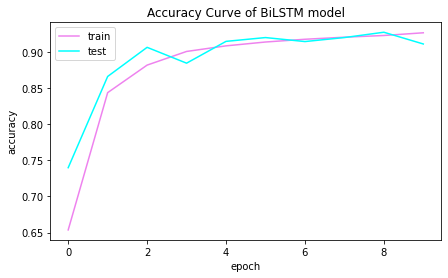

In [49]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of accuracy vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['accuracy'], 'violet')
plt.plot(history2['val_accuracy'],'cyan')

plt.title('Accuracy Curve of BiLSTM model')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper left');

### Loss Curve of our trained BiLSTM

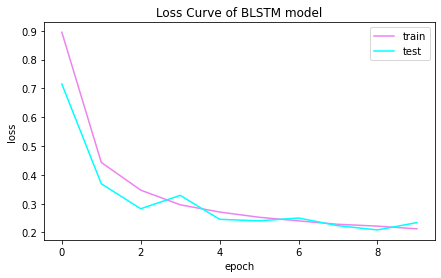

In [50]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of loss vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['loss'], 'violet')
plt.plot(history2['val_loss'], 'cyan')

plt.title('Loss Curve of BLSTM model')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper right');

## **Models Comparision**
The table below tabulates all the score accuracies from each model for a clear comparision.

In [51]:
result = pd.DataFrame({ 'Classifiers': ['DecisionTree Classifier', 'RandomForest Classifier','GradientBoosting Classifier', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})

result

,Classifiers,Score
0,DecisionTree Classifier,0.993800
1,RandomForest Classifier,0.995338
2,GradientBoosting Classifier,0.957456
3,Bidirectional LSTM,0.909868


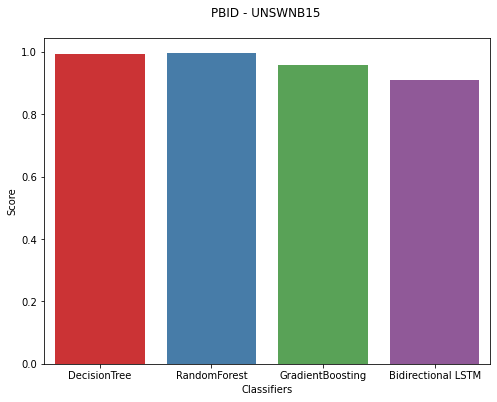

In [52]:
chart = pd.DataFrame({ 'Classifiers': ['DecisionTree', 'RandomForest','GradientBoosting', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})
plt.figure(figsize=(8,6))
ax=sns.barplot(data = chart, x = 'Classifiers', y = 'Score', palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), )
plt.title('PBID - UNSWNB15 \n ', fontsize=12)
#plt.legend([],[], frameon=True)
plt.show()

From these tested models, the results table shows that Random Forest classifier boast a 94% accuracy. 
The Deep Learning Models are even not far behind which had 92% around for  BLSTM.

In conclusion, the Random Forest classifier out performs all the models in detecting intrusion on the network. DecisionTree classifier are a close second in detecting intrusions and giving reliable predictions.

Finally To evaluate more about these models, the ROC curve and Calibration plots for multi-class classification need to be implemented.

### **Performance Test**

As our problem is about detecting intrusions. So what we require is more recall than precision of our model. Let's explain this, recall is important where false negative is more important than false positive. Here as false negative case ( means a real instrusion not detected ) is costly and we cannot afford to let go the intrusion undetected. And precision is important where false positive is more imporant than false negative.

So the class which has more recall is class 3, as it has more recall and precision than other clasess as observed from figure below.

Importing required libraries

Separating features and target

and training one vs rest classifier


## **Plot the ROC Curve**

Basically, ROC curve is an evaluation technique for classification problems. It plots sensivity against specificity. Senstivity is another name for recall which is true positive rate and specificity is false negative rate.

We desire to maximize these two values. If we maximize senstivity, the specificity lowers and vice versa. It depends on scenario which one to prefer.

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc

In [54]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)
classes=le2.classes_

In [55]:
RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train,y_train)
y_pred =RF.predict(X_test)
pred_prob = RF.predict_proba(X_test)

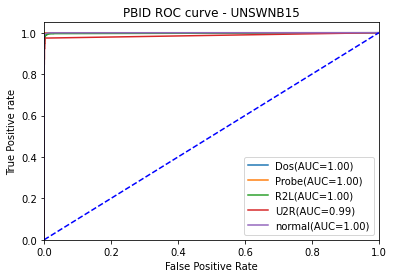

In [56]:
from sklearn.preprocessing import label_binarize
#binarize the y_values

y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], 
             label='%s(AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('PBID ROC curve - UNSWNB15')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()